# 09 - Alignment Metric Comparison

**RSA (Spearman) & CKA vs. RSA (Pearson)**

Purpose: verify that our main conclusions do not depend on the similarity metric.  
We re‑compute inter‑subject alignment with (i) Spearman RSA and (ii) unbiased linear CKA, then compare them to the Pearson RSA used in the paper. Results are consistent across metrics both at the ROI level and in connectivity structure.


## Imports

Load plotting/stat libraries and project helpers (HCP annotation, surface plotting, standardized colorbars/fonts).


In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from convergence.plotting import plot_faverage_parcelation
from convergence.figures import plot_cbar_set, setup_matplotlib_fonts
from convergence.figures_utils import add_hcp_names


setup_matplotlib_fonts()

## Data paths

Point to:
- HCP atlas metadata.
- Three alignment tables: Pearson RSA (baseline), Spearman RSA, and unbiased CKA.
Create an output folder for figures.


In [2]:
derivatives = Path("../derivatives")
nsd_folder = derivatives / "nsd"

hcp_filename = derivatives / "metadata" / "hcp.csv"

# Alignment files
rsa_pearson_filename = nsd_folder / "rsa_subject_subject_alignment_shift_1_joined.parquet"
rsa_spearman_filename = nsd_folder / "rsa_subject_subject_alignment_joined_1_spearman.parquet"
cka_filename = nsd_folder / "cka_subject_subject_alignment_shift_1_joined.parquet"

# Output folder
figure_folder= Path("../figures")
output = figure_folder / "09_alignment_cka_vs_rsa"
output.mkdir(exist_ok=True, parents=True)

## ROI order (top‑30 reliability set)

Reuse the fixed `connectivity_order` (top 30 ROIs with highest within‑subject Pearson RSA) to keep matrix heatmaps consistent with other figures.


In [3]:
connectivity_order = ['V1','V2', 'V3', 'V4', 'V8', 
                      'V3A', 'V3B', 'V3CD', 'VVC', 
                      'VMV3', 'VMV2', 'VMV1', 'PHA1', 'PHA2', 'PHA3', 
                      'IP0', 'PGp', 'DVT', 'LO3', 'LO2', 'PIT', 'LO1', 
                      'FFC', 'PH', 
                      'TPOJ3', 'V4t', 'FST', 'MST', 'MT', 'TPOJ2']



Utility function to:
- Optionally keep only diagonal (ROI self‑alignment) or full ROI×ROI matrices.
- Select inter‑ vs. within‑subject comparisons.
- Average across subjects to yield group‑level estimates.


In [4]:
def load_group_wise(
    filename: Path,
    connectivity: bool = False,
    intersubject: bool = True,
    column: str = "similarity",
    original_column: str = "similarity"  # For compatibility with previous versions
):
    # Load alignment data
    df = pd.read_parquet(filename)
    if not connectivity:
        df = df.query("roi_x == roi_y")  # Get only diagonal elements
        df = df.rename(columns={"roi_x": "roi"})
        group = ["roi"]
    else:
        group = ["roi_x", "roi_y"]

    if intersubject:  # Intersubject: maintain only subject_i != subject_j comparison
        df = df.query("subject_i != subject_j")
    else:  # Within subject: maintain only subject_i == subject_j comparison
        df = df.query("subject_i == subject_j")

    # Aggregate across subjects to get group-wise alignment
    df = df.groupby(group)[original_column].mean().reset_index()
    df = df.rename(columns={original_column: column})
    return df

## Merge per‑ROI metrics

Load Spearman, Pearson, and CKA group‑means (diagonals only) and merge into a single table keyed by ROI.  
Attach HCP names/area info for colored scatterplots and later labeling.


In [5]:
df_spearman = load_group_wise(rsa_spearman_filename, column="spearman")
df_rsa = load_group_wise(rsa_pearson_filename, column="pearson")
df_cka = load_group_wise(cka_filename, column="cka", original_column="score")

# Merge dataframes
df = pd.merge(df_spearman, df_rsa, on="roi")
df = pd.merge(df, df_cka, on="roi")

# Add info of HCP MMP1.0 atlas names
hcp_columns = ["roi", "name", "mne_name", "area", "area_id", "area_color"]
df = add_hcp_names(df, hcp_filename, hcp_columns=hcp_columns)
df

,roi,spearman,pearson,cka,name,mne_name,area,area_id,area_color
0,1,0.206217,0.194511,0.048921,V1,L_V1_ROI-lh,Primary Visual,0,#1f77b4
1,2,0.202392,0.210775,0.187690,MST,L_MST_ROI-lh,MT+ Visual Areas,6,#2ca02c
2,3,0.012134,0.012278,0.001417,V6,L_V6_ROI-lh,Dorsal Visual,5,#ff9896
3,4,0.187976,0.177940,0.053912,V2,L_V2_ROI-lh,Early Visual (V2-4),1,#aec7e8
4,5,0.136741,0.125448,0.037823,V3,L_V3_ROI-lh,Early Visual (V2-4),1,#aec7e8
...,...,...,...,...,...,...,...,...,...
175,176,0.004031,0.004292,0.001181,STSva,L_STSva_ROI-lh,Auditory Association,13,#f7b6d2
176,177,0.001873,0.001881,0.000226,TE1m,L_TE1m_ROI-lh,Lateral Temporal,4,#d62728
177,178,0.000301,0.000320,0.000162,PI,L_PI_ROI-lh,Insula & Frontal Operculum,14,#7f7f7f
178,179,0.001501,0.001305,0.000105,a32pr,L_a32pr_ROI-lh,Anterior Cingulate & mPFC,18,#17becf


Compute per-roi metrics correlations

In [6]:
df[["spearman", "pearson", "cka"]].corr(method="spearman").round(3)

,spearman,pearson,cka
spearman,1.000,0.999,0.922
pearson,0.999,1.000,0.929
cka,0.922,0.929,1.000


## Cortical surface maps (Spearman & CKA)

Project each metric onto fsaverage (LH) for three canonical views (ventral, medial, lateral).  
Color ranges match each metric’s empirical spread (±0.30 for Spearman, ±0.25 for CKA).  
Interpretation: spatial patterns (strong alignment in visual cortex hubs) are preserved across metrics.


In [7]:
views = ["ventral", "medial", "lateral", "caudal"]
surface_folder = output / "01_metric_surfaces"
surface_folder.mkdir(exist_ok=True, parents=True)
measures = ((0.3, "spearman"), (0.25, "cka"))

for vmax, column in measures:
    brain = plot_faverage_parcelation(
        df,
        value_column=column,
        normalize=(-vmax, vmax),
        cmap="RdBu_r",
        default_color="lightgrey",
        default_value=None,
        hemisphere="lh",
    )
    for view in views:
        brain_filename = surface_folder / f"01_surface_{column}_{view}_{vmax:.2f}.png"
        brain.show_view(view)
        brain.save_image(brain_filename, mode="rgba")
    brain.close()

Quick visual check

Display one saved PNG to verify surface.


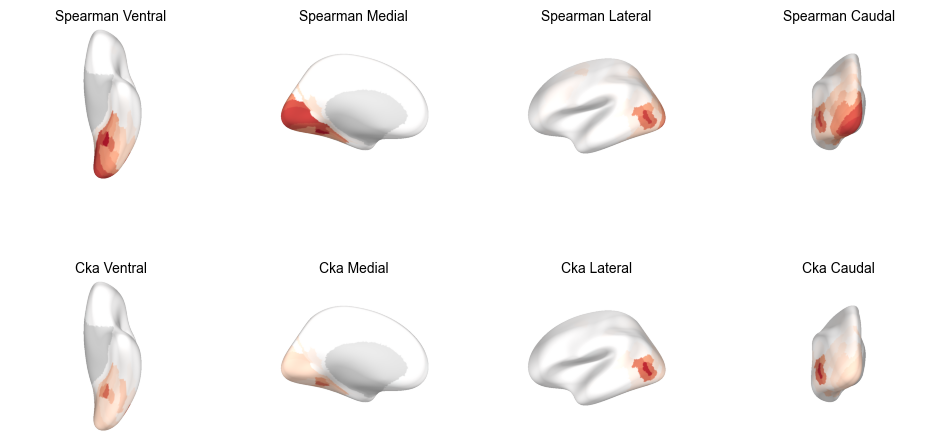

In [8]:
fig, axes = plt.subplots(2, len(views), figsize=(len(views) * 3, 2*3))

for j, (vmax, column) in enumerate(measures):
    for i, view in enumerate(views):
        img_file = surface_folder / f"01_surface_{column}_{view}_{vmax:.2f}.png"
        img = plt.imread(img_file)
        axes[j, i].imshow(img)
        axes[j, i].axis("off")
        axes[j, i].set_title(f"{column.capitalize()} {view.capitalize()}", fontsize=10)
        

## Connectivity matrices (top‑30 ROIs)

Compute group‑average inter‑subject alignment for Spearman and CKA across all ROI pairs, pivot to matrices, and reorder with `connectivity_order`.  

In [9]:
# Load tables roi_x x roi_y of inter-subject alignment group averaged
df_spearman = load_group_wise(rsa_spearman_filename, connectivity=True)
df_spearman = add_hcp_names(df_spearman, hcp_filename)
df_spearman = df_spearman.pivot(index="name_x", columns="name_y", values="similarity")
df_spearman = df_spearman.loc[connectivity_order, connectivity_order]
df_cka = load_group_wise(cka_filename, connectivity=True, original_column="score")
df_cka = add_hcp_names(df_cka, hcp_filename)
df_cka = df_cka.pivot(index="name_x", columns="name_y", values="similarity")
df_cka = df_cka.loc[connectivity_order, connectivity_order]

## Comparison panel

Four subplots:
1. **Pearson vs Spearman** scatter (ROI points colored by HCP area).  
2. **Spearman connectivity** matrix.  
3. **Pearson vs CKA** scatter.  
4. **CKA connectivity** matrix.

Notes:
- Slopes cluster tightly around the identity line; top‑20 ROIs by Pearson are annotated (labels exported in SVG for manual tidy‑up).
- Connectivity blocks are visually indistinguishable across metrics (minor scale differences only or sign-related differences of unbiased cka).


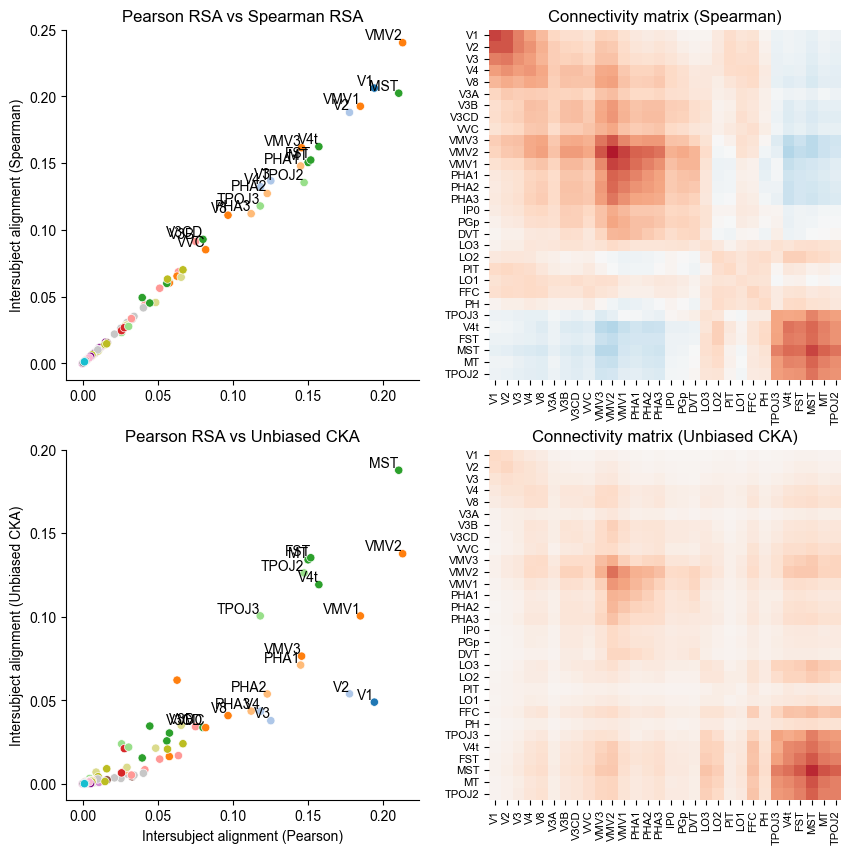

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten()

# Extract palette from hcp common colors
palette = df[["area", "area_color"]].drop_duplicates().set_index("area").area_color.to_dict()

# Plot scatter of pearson vs [spearman, cka]
sns.scatterplot(
    data=df, x="pearson", y="spearman", hue="area", palette=palette, ax=ax1, legend=False
)
sns.scatterplot(data=df, x="pearson", y="cka", hue="area", palette=palette, ax=ax3, legend=False)

# Plot spearman connectivity matrix
heatmap_kwars = dict(cbar=False, 
                     cmap="RdBu_r", 
                     xticklabels=connectivity_order,  
                     yticklabels=connectivity_order)
sns.heatmap(df_spearman, vmin=-0.3, vmax=0.3, ax=ax2, **heatmap_kwars)
sns.heatmap(df_cka,  vmin=-0.25, vmax=0.25, ax=ax4, **heatmap_kwars)

# Configure axes: ax1 (Spearman scatter)
ax1.set_title("Pearson RSA vs Spearman RSA")
ax1.set_ylabel(r"Intersubject alignment (Spearman)")
ax1.set_xlabel("")
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax1.set_ylim(None, 0.25)
sns.despine(ax=ax1)

# Configure axes: ax3 (CKA scatter)
ax3.set_title("Pearson RSA vs Unbiased CKA")
ax3.set_xlabel(r"Intersubject alignment (Pearson)")
ax3.set_ylabel(r"Intersubject alignment (Unbiased CKA)")
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax3.set_ylim(None, 0.2)
sns.despine(ax=ax3)

# Configure axes: ax2 (Spearman connectivity matrix)
ax2.set_title("Connectivity matrix (Spearman)")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.tick_params(axis="x", labelsize=8)
ax2.tick_params(axis="y", labelsize=8)

# Configure axes: ax4 (CKA connectivity matrix)
ax4.set_title("Connectivity matrix (Unbiased CKA)")
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.tick_params(axis="x", labelsize=8)
ax4.tick_params(axis="y", labelsize=8)


df_top_rois = df.nlargest(20, "pearson")
text_options = dict(fontsize=10, ha="right", va="bottom")
for _, row in df_top_rois.iterrows():
    ax1.text(row["pearson"],row["spearman"], row["name"], **text_options)
    ax3.text(row["pearson"], row["cka"], row["name"], **text_options)

# Save as svg to edit the text labels
filename = output / "02_figure_metric_comparison.svg"
fig.savefig(filename, bbox_inches='tight', transparent=True)

## Colorbar panels

Export standalone colorbars for Spearman RSA and CKA to maintain manuscript‑wide consistency (ranges chosen to match each panel above).


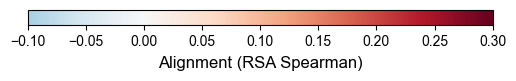

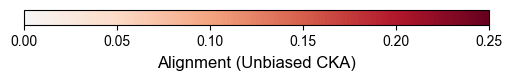

In [11]:
title = "Alignment (RSA Spearman)"
filename = output / "03_figure_metric_comparison_cbar_spearman.pdf"
plot_cbar_set(title=title, filename=filename, vmin=-0.1, vmax=0.3, locator=0.05)

title = "Alignment (Unbiased CKA)" # Linear kernel CKA
filename = output / "03_figure_metric_comparison_cbar_cka.pdf"
plot_cbar_set(title=title, filename=filename, vmin=0, vmax=0.25, locator=0.05)

## Conclusion

Changing the metric (Pearson → Spearman → unbiased CKA) leaves intact:

- **ROI ranking** of alignment strength,  
- **Hub‑level blocks** in connectivity matrices,  
- **Cortical topography** of alignment.

**Metric‑specific nuances**

- **Unbiased CKA is sign‑agnostic** (it measures dependence, not correlation direction), so it cannot distinguish positive vs. negative RSA (e.g., LOTC vs. early visual).  
- **CKA is more sensitive to low‑rank structure**, slightly inflating LOTC alignment and deflating primary visual alignment relative to RSA.  
- **Pearson and Spearman RSA correlate > 0.99**, with Spearman giving higher values, as expected for rank‑based robustness.

**Conclusion:** The core findings are robust to similarity metric; effects are not artifacts of using Pearson RSA.
